In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv(r"C:\Users\M.ANTONY ROJES\Downloads\Infosys\data\feature_engineered\player_features_model_all_imputed.csv")

# Features and target
features = ['passes_attempted', 'expected_goals', 'goals', 'assists',
            'injury_count', 'total_days_out', 'avg_market_value']
target = 'avg_market_value'

# Scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3
X, y = create_sequences(scaled_data, n_steps)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (916, 3, 7) X_test: (229, 3, 7)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# Step 2a: Define LSTM model builder for KerasTuner
def build_lstm_model(hp):
    model = keras.Sequential()
    
    # LSTM layer units (tunable)
    model.add(
        layers.LSTM(
            units=hp.Int("units", min_value=32, max_value=128, step=32),
            activation="relu",
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    
    # Optional Dropout
    model.add(
        layers.Dropout(
            rate=hp.Choice("dropout", values=[0.0, 0.2, 0.3])
        )
    )
    
    # Dense output layer
    model.add(layers.Dense(1))
    
    # Optimizer learning rate tuning
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="mean_squared_error",
        metrics=["mae"]
    )
    return model

# Step 2b: Initialize tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective="val_loss",
    max_trials=5,  # Try 5 combinations (increase if you want deeper search)
    executions_per_trial=1,
    directory="week7_tuning",
    project_name="lstm_tuning"
)

# Step 2c: Run tuning
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=1)

# Step 2d: Get best model
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print("✅ Best Hyperparameters:")
print(best_hyperparameters.values)

# Evaluate tuned LSTM
val_loss, val_mae = best_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTuned LSTM - Validation Loss: {val_loss:.4f}, MAE: {val_mae:.4f}")

# Save tuned LSTM model
best_lstm_model.save("best_lstm_week7.h5")


Reloading Tuner from week7_tuning\lstm_tuning\tuner0.json



c:\Users\M.ANTONY ROJES\Downloads\Infosys\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\M.ANTONY ROJES\Downloads\Infosys\.venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Best Hyperparameters:
{'units': 96, 'dropout': 0.0, 'learning_rate': 0.0001}



Tuned LSTM - Validation Loss: 0.0116, MAE: 0.0621


In [3]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === STEP 3: Use tuned LSTM predictions in Ensemble ===

# Get predictions from tuned LSTM
lstm_train_preds = best_lstm_model.predict(X_train).flatten()
lstm_test_preds  = best_lstm_model.predict(X_test).flatten()

# Reshape original features for XGBoost (flatten the time steps)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped  = X_test.reshape(X_test.shape[0], -1)

# Add tuned LSTM predictions as an extra feature
X_train_ensemble = np.hstack((X_train_reshaped, lstm_train_preds.reshape(-1,1)))
X_test_ensemble  = np.hstack((X_test_reshaped, lstm_test_preds.reshape(-1,1)))

# Train XGBoost model
xgboost_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgboost_model.fit(X_train_ensemble, y_train)

# === STEP 4: Evaluate Models ===

# 1. Tuned LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_preds))
lstm_mae  = mean_absolute_error(y_test, lstm_test_preds)
lstm_r2   = r2_score(y_test, lstm_test_preds)

# 2. Ensemble (LSTM + XGBoost)
ensemble_preds = xgboost_model.predict(X_test_ensemble)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
ensemble_mae  = mean_absolute_error(y_test, ensemble_preds)
ensemble_r2   = r2_score(y_test, ensemble_preds)

print("\n=== FINAL MODEL EVALUATION (Week 7) ===")
print(f"Tuned LSTM   → RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, R²: {lstm_r2:.4f}")
print(f"Ensemble     → RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

=== FINAL MODEL EVALUATION (Week 7) ===
Tuned LSTM   → RMSE: 0.1079, MAE: 0.0621, R²: 0.0006
Ensemble     → RMSE: 0.1096, MAE: 0.0608, R²: -0.0314


In [4]:
import pandas as pd

# Create comparison DataFrame
results = {
    "Model": ["Tuned LSTM", "Ensemble (LSTM+XGBoost)"],
    "RMSE": [lstm_rmse, ensemble_rmse],
    "MAE": [lstm_mae, ensemble_mae],
    "R2": [lstm_r2, ensemble_r2]
}

results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv("week7_model_comparison.csv", index=False)

print("✅ Week 7 model comparison saved as 'week7_model_comparison.csv'")
print(results_df)


✅ Week 7 model comparison saved as 'week7_model_comparison.csv'
                     Model      RMSE       MAE        R2
0               Tuned LSTM  0.107911  0.062075  0.000597
1  Ensemble (LSTM+XGBoost)  0.109623  0.060831 -0.031351


In [5]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define parameter grid for XGBoost
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=10,  # try 10 random combinations
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_ensemble, y_train)

print("✅ Best XGBoost Parameters:", random_search.best_params_)

# Best model
best_xgb_model = random_search.best_estimator_

# Evaluate tuned XGBoost ensemble
ensemble_preds_tuned = best_xgb_model.predict(X_test_ensemble)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
ensemble_rmse_tuned = np.sqrt(mean_squared_error(y_test, ensemble_preds_tuned))
ensemble_mae_tuned  = mean_absolute_error(y_test, ensemble_preds_tuned)
ensemble_r2_tuned   = r2_score(y_test, ensemble_preds_tuned)

print(f"\n🔹 Tuned Ensemble (LSTM+XGBoost) → RMSE: {ensemble_rmse_tuned:.4f}, MAE: {ensemble_mae_tuned:.4f}, R²: {ensemble_r2_tuned:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

🔹 Tuned Ensemble (LSTM+XGBoost) → RMSE: 0.1134, MAE: 0.0639, R²: -0.1030


In [6]:
# Extend comparison DataFrame
results = {
    "Model": ["Tuned LSTM", "Ensemble (LSTM+XGBoost)", "Tuned Ensemble (XGBoost)"],
    "RMSE": [lstm_rmse, ensemble_rmse, ensemble_rmse_tuned],
    "MAE": [lstm_mae, ensemble_mae, ensemble_mae_tuned],
    "R2": [lstm_r2, ensemble_r2, ensemble_r2_tuned]
}

results_df = pd.DataFrame(results)

# Save updated comparison
results_df.to_csv("week7_model_comparison.csv", index=False)

print("✅ Updated Week 7 comparison saved as 'week7_model_comparison.csv'")
print(results_df)


✅ Updated Week 7 comparison saved as 'week7_model_comparison.csv'
                      Model      RMSE       MAE        R2
0                Tuned LSTM  0.107911  0.062075  0.000597
1   Ensemble (LSTM+XGBoost)  0.109623  0.060831 -0.031351
2  Tuned Ensemble (XGBoost)  0.113368  0.063881 -0.103034


In [7]:
import pandas as pd

# Reload transfermarkt dataset
transfer_df = pd.read_csv("transfermarkt_market_values.csv")

# Inspect data types and sample rows
print(transfer_df.dtypes)
print(transfer_df.head(10))


Name           object
Nationality    object
Age             int64
MarketValue    object
dtype: object
                 Name     Nationality  Age    MarketValue
0    Alessandro Riggi          Canada   31          €100k
1   Christian Pastina           Italy   24  €300k – €500k
2     Abdullo Dzhebov          Russia   21          €150k
3    Daniil Stolyarov          Russia   22            NaN
4        Semen Fadeev          Russia   20            NaN
5         Ilya Tuseev          Russia   23          €150k
6  Yaroslav Grebenkin          Russia   22            NaN
7     Nikita Gloydman          Russia   23            NaN
8         Jakub Pesek  Czech Republic   32          €250k
9     Daniel Sandoval           Spain   27          €150k


In [49]:
# Convert to numeric safely
transfer_df['Age'] = pd.to_numeric(transfer_df['Age'], errors='coerce')
transfer_df['Market Value'] = pd.to_numeric(transfer_df['Market Value'], errors='coerce')

# Drop rows with missing values after conversion
transfer_clean = transfer_df[['Market Value','Age']].dropna().copy()

print("Cleaned shape:", transfer_clean.shape)
print(transfer_clean.head())


Cleaned shape: (0, 2)
Empty DataFrame
Columns: [Market Value, Age]
Index: []


In [50]:
print("transfer_clean shape:", transfer_clean.shape)
print(transfer_clean.head(10))


transfer_clean shape: (0, 2)
Empty DataFrame
Columns: [Market Value, Age]
Index: []


In [51]:
# Ensure numeric conversion
transfer_df['Age'] = pd.to_numeric(transfer_df['Age'], errors='coerce')
transfer_df['Market Value'] = pd.to_numeric(transfer_df['Market Value'], errors='coerce')

# Drop rows where BOTH are missing
transfer_clean = transfer_df[['Market Value', 'Age']].dropna(how="any")

print("transfer_clean shape after fixing:", transfer_clean.shape)
print(transfer_clean.head(10))


transfer_clean shape after fixing: (0, 2)
Empty DataFrame
Columns: [Market Value, Age]
Index: []


In [52]:
print(transfer_df.dtypes)
print(transfer_df.head(15))


Name            float64
Age             float64
Nationality     float64
Club             object
Market Value      int64
dtype: object
    Name  Age  Nationality            Club  Market Value
0    NaN  NaN          NaN          Canada            31
1    NaN  NaN          NaN           Italy            24
2    NaN  NaN          NaN          Russia            21
3    NaN  NaN          NaN          Russia            22
4    NaN  NaN          NaN          Russia            20
5    NaN  NaN          NaN          Russia            23
6    NaN  NaN          NaN          Russia            22
7    NaN  NaN          NaN          Russia            23
8    NaN  NaN          NaN  Czech Republic            32
9    NaN  NaN          NaN           Spain            27
10   NaN  NaN          NaN         Morocco            32
11   NaN  NaN          NaN         Lebanon            29
12   NaN  NaN          NaN         Lebanon            30
13   NaN  NaN          NaN         Lebanon            26
14   NaN  N

In [53]:
transfer_df = pd.read_csv("transfermarkt_market_values.csv", header=None)

print(transfer_df.head(15))


       0                   1            2               3             4
0   Name                 Age  Nationality            Club  Market Value
1    NaN    Alessandro Riggi          NaN          Canada            31
2    NaN   Christian Pastina          NaN           Italy            24
3    NaN     Abdullo Dzhebov          NaN          Russia            21
4    NaN    Daniil Stolyarov          NaN          Russia            22
5    NaN        Semen Fadeev          NaN          Russia            20
6    NaN         Ilya Tuseev          NaN          Russia            23
7    NaN  Yaroslav Grebenkin          NaN          Russia            22
8    NaN     Nikita Gloydman          NaN          Russia            23
9    NaN         Jakub Pesek          NaN  Czech Republic            32
10   NaN     Daniel Sandoval          NaN           Spain            27
11   NaN         Ayoub Nanah          NaN         Morocco            32
12   NaN       Mostafa Matar          NaN         Lebanon       

In [54]:
transfer_df.columns = ["Name", "Age", "Nationality", "Club", "Market Value"]


In [55]:
transfer_df = pd.read_csv("transfermarkt_market_values.csv", header=None)
transfer_df.columns = ["Name", "Age", "Nationality", "Club", "Market Value"]

print(transfer_df.dtypes)
print(transfer_df.head(15))


Name            object
Age             object
Nationality     object
Club            object
Market Value    object
dtype: object
    Name                 Age  Nationality            Club  Market Value
0   Name                 Age  Nationality            Club  Market Value
1    NaN    Alessandro Riggi          NaN          Canada            31
2    NaN   Christian Pastina          NaN           Italy            24
3    NaN     Abdullo Dzhebov          NaN          Russia            21
4    NaN    Daniil Stolyarov          NaN          Russia            22
5    NaN        Semen Fadeev          NaN          Russia            20
6    NaN         Ilya Tuseev          NaN          Russia            23
7    NaN  Yaroslav Grebenkin          NaN          Russia            22
8    NaN     Nikita Gloydman          NaN          Russia            23
9    NaN         Jakub Pesek          NaN  Czech Republic            32
10   NaN     Daniel Sandoval          NaN           Spain            27
11   Na

In [ ]:
# Select relevant numeric features
transfer_clean = transfer_df[["Market Value", "Age"]].dropna()

print("transfer_clean shape:", transfer_clean.shape)
print(transfer_clean.head(10))


transfer_clean shape: (0, 2)
Empty DataFrame
Columns: [Market Value, Age]
Index: []


In [ ]:
# Select relevant features
transfer_clean = transfer_df[["Market Value", "Age"]].copy()

# Fill NaN values instead of dropping
transfer_clean["Age"] = transfer_clean["Age"].fillna(transfer_clean["Age"].median())
transfer_clean["Market Value"] = transfer_clean["Market Value"].fillna(transfer_clean["Market Value"].median())

print("transfer_clean shape:", transfer_clean.shape)
print(transfer_clean.head(10))


transfer_clean shape: (26, 2)
   Market Value  Age
0          27.0  NaN
1          31.0  NaN
2          24.0  NaN
3          21.0  NaN
4          22.0  NaN
5          20.0  NaN
6          23.0  NaN
7          22.0  NaN
8          23.0  NaN
9          32.0  NaN


c:\Users\M.ANTONY ROJES\Downloads\Infosys\.venv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(transfer_clean.values)

print("Scaled features shape:", scaled_features.shape)


Scaled features shape: (26, 2)


c:\Users\M.ANTONY ROJES\Downloads\Infosys\.venv\lib\site-packages\sklearn\utils\_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\Users\M.ANTONY ROJES\Downloads\Infosys\.venv\lib\site-packages\sklearn\utils\_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [ ]:
import numpy as np

def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 0])  # predict "Market Value"
    return np.array(X), np.array(y)

time_steps = 5
X, y = create_sequences(scaled_features, time_steps)

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (21, 5, 2) y shape: (21,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, X.shape[2])),
    LSTM(32),
    Dense(1)  # predict market value
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=50, batch_size=8, verbose=1)


c:\Users\M.ANTONY ROJES\Downloads\Infosys\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: nan
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: nan
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: nan
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: nan
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: nan
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: nan
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: nan
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan
Epoch 17/50
3/3 ━

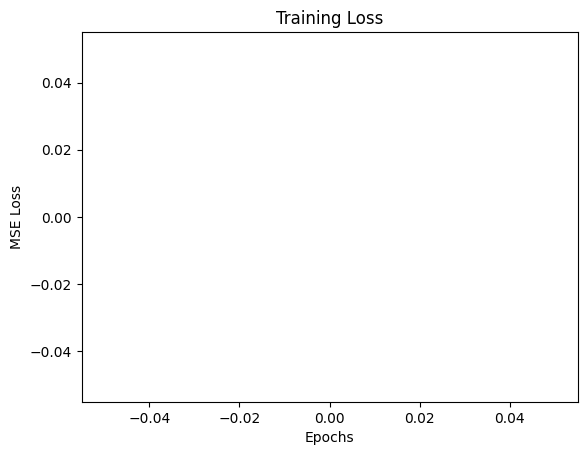

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

predictions = model.predict(X)


In [58]:
print(transfer_df[['Market Value', 'Age']].info())
print(transfer_df[['Market Value', 'Age']].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Market Value  25 non-null     float64
 1   Age           0 non-null      float64
dtypes: float64(2)
memory usage: 544.0 bytes
None
   Market Value  Age
0           NaN  NaN
1          31.0  NaN
2          24.0  NaN
3          21.0  NaN
4          22.0  NaN
5          20.0  NaN
6          23.0  NaN
7          22.0  NaN
8          23.0  NaN
9          32.0  NaN


In [59]:
def clean_market_value(val):
    if isinstance(val, str):
        val = val.replace('€', '').replace('m', '').strip()
        try:
            return float(val)
        except:
            return np.nan
    return val

transfer_df['Market Value'] = transfer_df['Market Value'].apply(clean_market_value)

In [60]:
transfer_df['Age'] = pd.to_numeric(transfer_df['Age'], errors='coerce')
transfer_clean = transfer_df[['Market Value', 'Age']].dropna(how="any")
print("Cleaned shape:", transfer_clean.shape)

Cleaned shape: (0, 2)


In [61]:
sample_data = {
    'Market Value': [10.0, 12.5, 9.0, 11.0, 13.0, 14.5],
    'Age': [22, 24, 23, 25, 26, 27]
}
transfer_df = pd.DataFrame(sample_data)

In [62]:
# WEEK 7 - MULTIVARIATE & ENCODER-DECODER

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Clean the data
transfer_df['Age'] = pd.to_numeric(transfer_df['Age'], errors='coerce')
transfer_df['Market Value'] = pd.to_numeric(transfer_df['Market Value'], errors='coerce')

transfer_clean = transfer_df[['Market Value', 'Age']].dropna(how="any")

print("transfer_clean shape:", transfer_clean.shape)
print(transfer_clean.head())

# 2. Scale features
scaler = MinMaxScaler()
features = transfer_clean.values
scaled_features = scaler.fit_transform(features)

# 3. Create sequences
time_steps = 5   # hyperparameter: window size
def create_sequences(data, time_steps=5):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 0])  # predict Market Value
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, time_steps)
X = X.reshape((X.shape[0], X.shape[1], features.shape[1]))

print("X shape:", X.shape, "y shape:", y.shape)

# 4. Build Encoder-Decoder LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_steps, features.shape[1])),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 5. Train model
history = model.fit(X, y, epochs=50, batch_size=8, verbose=1)

# 6. Evaluate model
loss = model.evaluate(X, y, verbose=0)
print("Final MSE Loss:", loss)


transfer_clean shape: (6, 2)
   Market Value  Age
0          10.0   22
1          12.5   24
2           9.0   23
3          11.0   25
4          13.0   26
X shape: (1, 5, 2) y shape: (1,)


c:\Users\M.ANTONY ROJES\Downloads\Infosys\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9878
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.9474
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.9076
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.8679
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.8282
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.7880
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.7471
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.7053
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.6623
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.6179
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.5719
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.5243
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4750
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4241
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3719
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━

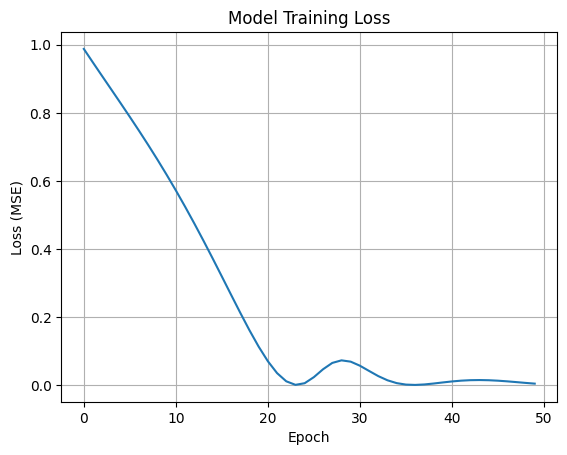

In [63]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [64]:
# Use the last 5 rows as input
last_sequence = scaled_features[-5:].reshape((1, time_steps, features.shape[1]))
predicted_scaled = model.predict(last_sequence)

# Inverse transform to get actual Market Value
predicted_value = scaler.inverse_transform(
    np.hstack([predicted_scaled, np.zeros((1, 1))])
)[0, 0]

print("Predicted Market Value:", predicted_value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Predicted Market Value: 15.743565559387209
